In [1]:
# Установка необходимых библиотек
# !pip install python-docx requests pandas

In [2]:
import os
from docx import Document
import requests
import pandas as pd
import json
import re
import pprint
# from google.colab import files

# !pip install pymupdf

import fitz  # импорт библиотеки PyMuPDF
import time
from tqdm import tqdm

#### Перевод pdf в txt файлы, 1-ый вариант


In [3]:
def pdf_to_text(pdf_path):
    txt_path = pdf_path.replace('.pdf', '.txt')  

    # Открытие PDF файла
    doc = fitz.open(pdf_path)

    # Открытие файла для записи текста
    with open(txt_path, 'w', encoding='utf-8') as text_file:
        # Перебор страниц и извлечение текста
        for page_number in range(len(doc)):
            page = doc.load_page(page_number)  # загрузка страницы по номеру
            text = page.get_text()  # извлечение текста со страницы
            text_file.write(f"Текст со страницы {page_number + 1}:\n{text}\n")  # запись текста в файл

    # Закрытие документа
    doc.close()

    return txt_path 

#### Перевод pdf в txt файлы, 2-ой вариант

In [4]:
# from pdfminer.high_level import extract_text

# pdf_path = r"C:\Users\User\Documents\MFTI_VKR\__parsing\1\75483.pdf"
# txt_path = pdf_path.replace('.pdf', '.txt')

# # Извлечение текста из PDF файла
# text = extract_text(pdf_path)

# # Запись текста в файл
# with open(txt_path, 'w', encoding='utf-8') as text_file:
#     text_file.write(text)


#### Перевод pdf в txt файлы, ЦИКЛ по файлам скачанным ранее


In [5]:
def process_pdf_files(file_list_path):
    # Чтение файла со списком путей к PDF файлам
    with open(file_list_path, 'r', encoding='utf-8') as file:
        pdf_paths = file.readlines()
    
    # Удаление символов новой строки из путей
    pdf_paths = [path.strip() for path in pdf_paths]

    created_txt_paths = []

    # Подсчет количества файлов
    total_files = len(pdf_paths)
    print(f"Количество файлов к преобразованию: {total_files}")

    # Начало отсчета времени
    start_time = time.time()

    # Цикл для вызова функции для каждого PDF файла с прогресс-баром
    for pdf_path in tqdm(pdf_paths, desc="Преобразование файлов", unit="file"):
        txt_path = pdf_to_text(pdf_path)
        created_txt_paths.append(txt_path)

    # Конец отсчета времени
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Запись списка созданных текстовых файлов в новый файл
    output_file_list_path = file_list_path.replace('_text_path.txt', '_text_path_txt.txt')
    with open(output_file_list_path, 'w', encoding='utf-8') as output_file:
        for txt_path in created_txt_paths:
            output_file.write(txt_path + '\n')

    print(f"Преобразовано {total_files} файлов за {elapsed_time:.2f} секунд")

# Путь к файлу со списком PDF файлов
file_list_path = r"C:\Users\User\Documents\MFTI_VKR\__parsing\1\_text_path.txt"

# Вызов функции для обработки списка PDF файлов
process_pdf_files(file_list_path)


Количество файлов к преобразованию: 74


Преобразование файлов: 100%|██████████| 74/74 [00:03<00:00, 21.33file/s]

Преобразовано 74 файлов за 3.49 секунд


#### Предварительная обработку текста с помощью spacy, сохранение в новые файлы txt

In [21]:
import spacy

nlp = spacy.load("ru_core_news_sm")
# nlp = spacy.load("en_core_web_sm")

# Функция предварительной обработки текста
def preprocess_text(input_file_path, output_file_path):
    # Чтение текста из файла
    with open(input_file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    # Приведение текста к нижнему регистру
    text = text.lower()
    
    # Применение языковой модели spacy
    doc = nlp(text)
    
    # Удаление стоп-слов и знаков препинания, а также лемматизация
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    # Соединение токенов обратно в строку
    processed_text = ' '.join(tokens)
    
    # Запись обработанного текста в новый файл
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(processed_text)

        
# Функция извлечения сущностей и отношений
def extract_entities_relations(text):
    # Пропускаем текст через NLP-пайплайн spaCy для получения объекта документа
    doc = nlp(text)
    
    # Извлекаем именованные сущности из документа и сохраняем их в виде списка кортежей (текст сущности, метка сущности)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    
    # Создаем пустой список для хранения отношений
    relations = []
    
    # Проходим по каждому токену в документе
    for token in doc:
        # Проверяем, является ли токен подлежащим (nsubj) или прямым дополнением (dobj)
        if token.dep_ in ('nsubj', 'dobj'):
            # Добавляем отношение в список в виде кортежа (глава, хвост, тип отношения)
            relations.append((token.head.text, token.text, token.dep_))
    
    # Возвращаем список сущностей и список отношений
    return entities, relations        

# Функция для обработки файлов
def process_files(file_list_path):
    # Получение директории, в которой находится файл со списком путей
    base_dir = os.path.dirname(file_list_path)
    
    with open(file_list_path, 'r', encoding='utf-8') as file:
        file_paths = file.readlines()
    
    file_paths = [path.strip() for path in file_paths]  # Удаление пробелов и переводов строк
    
    output_file_list = []  # Список для хранения путей созданных файлов
    entities_relations_dict = {}  # Словарь для хранения извлеченных сущностей и отношений
    
    for input_file_path in tqdm(file_paths, desc="Processing files"):
        output_file_path = f"{input_file_path[:-4]}-s.txt"
        preprocess_text(input_file_path, output_file_path)
        output_file_list.append(output_file_path)  # Добавление пути созданного файла в список
        
        # Чтение обработанного текста и извлечение сущностей и отношений
        with open(output_file_path, 'r', encoding='utf-8') as processed_file:
            processed_text = processed_file.read()
            entities, relations = extract_entities_relations(processed_text)
            entities_relations_dict[output_file_path] = (entities, relations)  # Сохранение данных в словарь
    
    
    # Запись списка созданных файлов в _text_path_txt_s.txt в той же директории
    output_file_list_path = os.path.join(base_dir, "_text_path_txt_s.txt")
    with open(output_file_list_path, 'w', encoding='utf-8') as output_file:
        for path in output_file_list:
            output_file.write(path + '\n')
    
    # Возвращаем словарь с сущностями и отношениями
    return entities_relations_dict

# Путь к файлу со списком файлов
# file_list_path = r"C:\Users\User\Documents\MFTI_VKR\__parsing\1\_text_path_txt.txt"

# Вызов функции
# process_files(file_list_path)


In [42]:
import networkx as nx
from pyvis.network import Network

# Функция для построения и визуализации графа
def build_and_visualize_graph(entities_relations_dict, output_html_file="graph.html"):
    net = Network(notebook=True, cdn_resources='in_line')
    
    nodes = set()
    edge_count = 0  # Счётчик рёбер
    
    for file, (entities, relations) in entities_relations_dict.items():
        for entity, label in entities:
            if entity not in nodes:
                # Добавляем узел с меткой
                print(f"Adding node: {entity} with label: {label}")
                net.add_node(entity, label=entity, title=label)
                nodes.add(entity)
        for head, tail, rel in relations:
            if head in nodes and tail in nodes:
                # Добавляем ребро между узлами
                print(f"Adding edge from {head} to {tail} with relation {rel}")
                net.add_edge(head, tail, title=rel)
                edge_count += 1
            else:
                print(f"Skipping edge from {head} to {tail} because one of the nodes is missing.")
    
    # Подсчёт количества узлов
    node_count = len(nodes)
    
    print(f"Total number of nodes: {node_count}")
    print(f"Total number of edges: {edge_count}")
    
    # Запись HTML файла вручную с указанием кодировки
    html_content = net.generate_html()
    with open(output_html_file, 'w', encoding='utf-8') as f:
        f.write(html_content)

In [28]:
# Путь к файлу со списком файлов
file_list_path = r"C:\Users\User\Documents\MFTI_VKR\__parsing\1\_text_path_txt.txt"

# Вызов функции
entities_relations = process_files(file_list_path)

Processing files: 100%|██████████| 74/74 [02:46<00:00,  2.25s/it]


In [43]:
# Построение и визуализация графа
build_and_visualize_graph(entities_relations)

Adding node: фгуп госнии га with label: ORG
Adding node: вс 5 with label: ORG
Adding node: иас млг with label: PER
Adding node: пм иас млг with label: PER
Adding node: вс with label: ORG
Adding node: вс .18 with label: ORG
Adding node: ат полный with label: PER
Adding node: иас мл with label: PER
Adding node: ата воздушный with label: PER
Adding node: га with label: ORG
Adding node: ати with label: PER
Adding node: ат изготовитель ати with label: PER
Adding node: сопровожде­ with label: ORG
Adding node: ат изготовитель ат with label: PER
Adding node: пк with label: ORG
Adding node: работчиком ат with label: LOC
Adding node: иас with label: ORG
Adding node: ат with label: ORG
Adding node: ат актуа­ with label: PER
Adding node: ат основа with label: PER
Adding node: еип with label: ORG
Adding node: изготовитель ат with label: PER
Adding node: пкл with label: LOC
Adding node: изготовитель ата with label: PER
Adding node: эксплуатант ата with label: PER
Adding node: ата with label: ORG
Add

### Aнализ текстов

#### Шаг 1: Чтение файлов и предварительная обработка

In [7]:
def read_files(file_list_path):
    with open(file_list_path, 'r', encoding='utf-8') as file:
        file_paths = file.readlines()
    
    file_paths = [path.strip() for path in file_paths]
    
    documents = {}
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            documents[file_path] = f.read()
    
    return documents

file_list_path_s = r"C:\Users\User\Documents\MFTI_VKR\__parsing\1\_text_path_txt_s.txt"
documents = read_files(file_list_path_s)


In [8]:
print(type(documents))

<class 'dict'>


#### Шаг 2: Подсчет частоты употребления слов, по каждому документу отдельно, и по всему массиву

In [9]:
from collections import Counter

nlp = spacy.load("ru_core_news_sm")

def count_word_frequencies(documents):
    word_frequencies = {}
    for file_path, text in tqdm(documents.items(), desc="Counting word frequencies"):
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        word_frequencies[file_path] = Counter(tokens)
    
    return word_frequencies

def count_total_word_frequencies(word_frequencies):
    total_frequencies = Counter()
    for frequencies in word_frequencies.values():
        total_frequencies.update(frequencies)
    
    return total_frequencies

word_frequencies = count_word_frequencies(documents)

word_frequencies = count_word_frequencies(documents)
total_word_frequencies = count_total_word_frequencies(word_frequencies)

Counting word frequencies: 100%|██████████| 74/74 [01:09<00:00,  1.07it/s]


In [10]:
print(type(word_frequencies))
print(type(total_word_frequencies))

<class 'dict'>
<class 'collections.Counter'>


In [61]:
#  Удаление попавших в термины "\n", "1"
words_to_remove = ["\n", "1"]
for file_path, frequencies in list(word_frequencies.items()):  # Преобразуем в список для безопасного удаления
    for word in list(frequencies.keys()):  # Перебираем копию ключей, чтобы можно было безопасно менять оригинал
        if any(char in word for char in words_to_remove):  # Проверяем наличие символов из words_to_remove в слове
            del frequencies[word]

for word in list(total_word_frequencies.keys()):  # Перебираем копию ключей, чтобы можно было безопасно менять оригинал
    if any(char in word for char in words_to_remove):
        del total_word_frequencies[word]



In [62]:
# Печать общей частоты слов по всем документам
print("Общая частота слов по всем документам:")
print(total_word_frequencies.most_common(20))  # Печать 20 наиболее упоминаемых слов

# Печать частоты слов для первых 5 документов
print("Частота слов по отдельным документам:")
for i, (file_path, frequencies) in enumerate(word_frequencies.items()):
    print(f"File Path: {file_path}")
    print(f"Word Frequencies: {frequencies.most_common(10)}")  # Печать 10 наиболее упоминаемых слов
    print("\n")
    if i == 4:  # Показать только первые 5 файлов
        break


Общая частота слов по всем документам:
[('безопасность', 3510), ('система', 2833), ('авиационный', 2213), ('организация', 2167), ('стандарт', 2083), ('риск', 2037), ('деятельность', 1672), ('требование', 1607), ('управление', 1562), ('обеспечение', 1536), ('гост', 1493), ('воздушный', 1461), ('технический', 1376), ('полёт', 1334), ('текст', 1298), ('страница', 1185), ('информация', 1161), ('вс', 1131), ('уровень', 1109), ('работа', 1106)]
Частота слов по отдельным документам:
File Path: C:\Users\User\Documents\MFTI_VKR\__parsing\1\51176-s.txt
Word Frequencies: [('вс', 199), ('иас', 156), ('млг', 154), ('эксплуатация', 89), ('вс.', 89), ('система', 75), ('информационный', 73), ('субъект', 68), ('информация', 67), ('дата', 61)]


File Path: C:\Users\User\Documents\MFTI_VKR\__parsing\1\51247-s.txt
Word Frequencies: [('пож', 149), ('жидкость', 135), ('самолёт', 109), ('поверхность', 82), ('применение', 70), ('температура', 67), ('тип', 64), ('раствор', 63), ('противообледенительный', 57), 

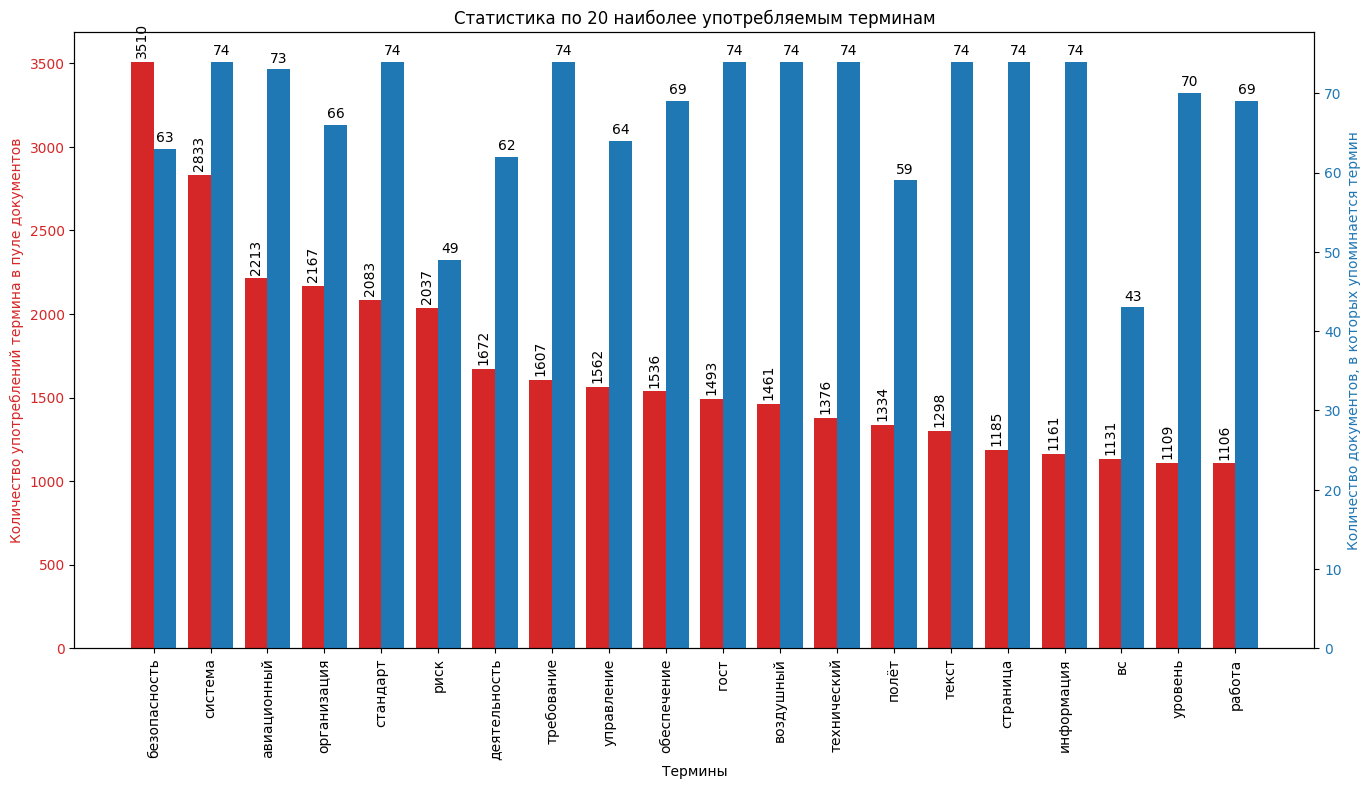

In [72]:
import matplotlib.pyplot as plt

# Построение графика
x = np.arange(len(common_words_sorted))
bar_width = 0.4

fig, ax1 = plt.subplots(figsize=(16, 8))

color1 = 'tab:red'
ax1.set_xlabel('Термины')
ax1.set_ylabel('Количество употреблений термина в пуле документов', color=color1)
bar1 = ax1.bar(x, word_usage, bar_width, color=color1, label='Количество употреблений термина в пуле документов')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Количество документов, в которых упоминается термин', color=color2)
bar2 = ax2.bar(x + bar_width, document_count, bar_width, color=color2, label='Количество документов, в которых упоминается термин')
ax2.tick_params(axis='y', labelcolor=color2)

# Добавление численных значений вертикально над столбцами "Количество употреблений"
for i, v in enumerate(word_usage):
    ax1.annotate(str(v), xy=(i, v), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', rotation=90)

for i, v in enumerate(document_count):
    ax2.annotate(str(v), xy=(i + bar_width, v), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(common_words_sorted, rotation=90)

plt.title('Статистика по 20 наиболее употребляемым терминам')

plt.show()



#### Шаг 3: Векторизация текстов

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_texts(documents):
    texts = list(documents.values())
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    return tfidf_matrix, vectorizer

tfidf_matrix, vectorizer = vectorize_texts(documents)


In [13]:
print(type(tfidf_matrix))
print(type(vectorizer))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


#### Шаг 4: Сравнение повторяемости слов

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def compare_texts(tfidf_matrix):
    similarities = cosine_similarity(tfidf_matrix)
    return similarities

similarities = compare_texts(tfidf_matrix)


In [15]:
print(type(similarities))
print(similarities)

<class 'numpy.ndarray'>
[[1.         0.05753142 0.09130626 ... 0.03648146 0.11523015 0.02653929]
 [0.05753142 1.         0.07995131 ... 0.0265999  0.04821668 0.03383021]
 [0.09130626 0.07995131 1.         ... 0.04176855 0.05027016 0.04345467]
 ...
 [0.03648146 0.0265999  0.04176855 ... 1.         0.04547551 0.02735268]
 [0.11523015 0.04821668 0.05027016 ... 0.04547551 1.         0.02031265]
 [0.02653929 0.03383021 0.04345467 ... 0.02735268 0.02031265 1.        ]]


#### Шаг 5: Анализ тематической структуры

In [16]:
from sklearn.decomposition import LatentDirichletAllocation

def topic_modeling(tfidf_matrix, n_topics=5):
    lda = LatentDirichletAllocation(n_components=n_topics)
    lda.fit(tfidf_matrix)
    return lda

lda_model = topic_modeling(tfidf_matrix)


In [17]:
print(type(lda_model))
print(lda_model)

<class 'sklearn.decomposition._lda.LatentDirichletAllocation'>
LatentDirichletAllocation(n_components=5)


#### Шаг 6: Выявление уникальных и общих слов

In [18]:
def unique_and_common_words(word_frequencies):
    unique_words = {}
    common_words = set(word_frequencies[list(word_frequencies.keys())[0]].keys())
    
    for file_path, frequencies in word_frequencies.items():
        words = set(frequencies.keys())
        unique_words[file_path] = words - common_words
        common_words &= words
    
    return unique_words, common_words

unique_words, common_words = unique_and_common_words(word_frequencies)


In [19]:
print(type(unique_words))
print(unique_words)

print(type(common_words))
print(common_words)

<class 'dict'>
{'C:\\Users\\User\\Documents\\MFTI_VKR\\__parsing\\1\\51176-s.txt': set(), 'C:\\Users\\User\\Documents\\MFTI_VKR\\__parsing\\1\\51247-s.txt': {'накопление', 'неоднократный', 'отрыв', 'нести', 'ная', 'наносить', 'тренировка', 'пературах', 'прогнозировать', 'обложной', '6.2.1', '4.4.6', '6.3.1', 'сти', 'вызывать', 'день', 'низкозамерза\xad', 'глав\xad', 'поверхность', 'разбавлять', 'коррозия', 'производиться', 'обеспече\xad', 'давле\xad', '6.4', 'fsaw', '6.4.3', 'прохождение', 'няется', 'sae', 'сойти', 'испарение', 'попасть', 'сдвиг', 'вытеснить', 'расплавить', 'замерза\xad', 'ляется', 'жвдкости', 'молетов', 'при\xad', 'занятие', '6.4.4', 'превалировать', 'примене\xad', 'влага', 'двухэтапную', 'покрыть', '6.3.3.11', 'скопление', 'выпадать', 'принимать', 'открыть', 'разумный', 'goslinfo.ru', 'сокращать', '4.4.4', 'крупа', 'зуемой', 'перенос', 'борт', '6.3.3.14', '6.2.4', 'комок', 'обледе\xad', 'ответить', 'насыщаться', 'ме\xad', 'превращаться', 'застойный', 'соответственно'

#### Шаг 7: Визуализация данных

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def clean_frequencies(frequencies):
    clean_freq = {}
    for k, v in frequencies.items():
        if isinstance(k, str) and isinstance(v, (int, float)):
            k = k.strip()  # Убираем пробелы в начале и конце строки
            if k and not any(char in k for char in "\n\t\r"):  # Убираем строки, содержащие переносы и табуляции
                clean_freq[k] = v
    return clean_freq

def visualize_word_frequencies(word_frequencies):
    for file_path, frequencies in word_frequencies.items():
        # Очистка частотных данных
        clean_freq = clean_frequencies(frequencies)
        
        # Генерация облака слов
        try:
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(clean_freq)
            
            # Создание нового графика
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            
            # Использование только имени файла без пути
            base_file_name = os.path.basename(file_path)
            plt.title(base_file_name)
            
            # Отображение графика
            plt.show()
        except ValueError as e:
            print(f"Error processing file {file_path}: {e}")
            print(f"Frequencies: {clean_freq}")

# Пример использования
visualize_word_frequencies(word_frequencies)